Demonstrate the base functionality of the firmware.  With a loop-back cable installed from the DAC output to the ADC input, this produces a tone at the output, reads it back, and demodulates back to DC.

The TopSoc class chooses the firmware based on the board, ZCU111 or ZCU216.

For the ZCU111, the loopback cable is from DAC229_T1_CH2 to ADC224_T0_CH0, (single ended)

For the ZCU216, the loopback cables are from  226 CH 0 and 230 CH0.  The P and N are separate, so you need two physical cables.  ADC Vin channels P 0_226 and N 01_226 connect to a tile, LMFB DAC 02. Connect the LMFB DAC 02 tile to the LMFB DAC 01 tile on the left side of the board.  You need two cables running from that LMFB DAC 01 tile to channels 0_230 and 2_230 in the DAC Vout connector. 


In [1]:
from mkids import TopSoc
from scipy.signal import welch
from numpy.fft import fftshift
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load bitstream with custom overlay
soc = TopSoc(force_init_clks=True)

resetting clocks: 245.76 491.52


In [3]:
freqs = np.arange(0, 2*soc.fsIn)
freqsAliased = np.zeros(len(freqs))
for i,freq in enumerate(freqs):
    freqsAliased[i]  = soc.fAliasedFromFToneScalar(freq)

Text(0, 0.5, 'aliased frequency')

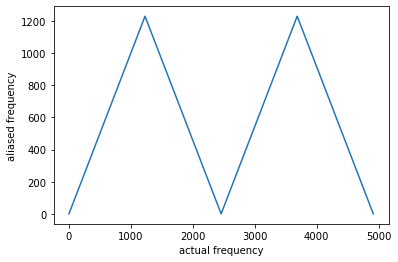

In [4]:
plt.plot(freqs, freqsAliased)
plt.xlabel("actual frequency")
plt.ylabel("aliased frequency")

In [5]:
fMixer = soc.fsIn/2
soc.set_mixer(fMixer) # MHz
foutRequested = soc.fsIn/2 + 123.456
soc.dds_out.alloff()
foutQuantized = soc.DF*np.round(foutRequested/soc.DF)
print("foutRequested, foutQuantized =",foutRequested, foutQuantized)

foutRequested, foutQuantized = 1352.2559999999999 1352.256005859375


In [6]:
# Create an output tone
pfb_ch, dds_freq, _, _ = soc.pfb_out.freq2ch(foutQuantized, soc.get_mixer())
print("output channel =",pfb_ch)
print("output DDS freq =",dds_freq)
soc.dds_out.ddscfg(ch=pfb_ch, f=dds_freq, g=0.9, fi=0.0)
soc.pfb_out.qout(0)

output channel = 51
output DDS freq = 1.056005859374962


In [7]:
# Set up the input dds and the streamer to read this tone
fInAliased = soc.fAliasedFromFToneScalar(foutQuantized)
print("foutQuantized =",foutQuantized)
print("fInAliased =",fInAliased)
decimation = 2
pfbInQout = 8
K, dds_freq, pdb_freq, ch = soc.pfb_in.freq2ch(np.array([fInAliased]))
print("K =",K, "dds_freq =",dds_freq)
stream, stream_idx = soc.chsel.ch2idx(K)
print("stream, stream_idx",stream,stream_idx)
inCh, offset = soc.inFreq2chOffset(fInAliased)
print("inCh =",inCh, "offset =",offset)
ntran, addr, bits = soc.chsel.ch2tran(inCh)
num_tran, tran_idx = soc.chsel.set(K)
print("num_tran, tran_idx",num_tran,tran_idx)
ntranByTone, streamByTone = soc.inFreq2NtranStream(np.array([fInAliased]))
print("ntranByTone, streamByTone",ntranByTone, streamByTone)

soc.pfb_in.qout(pfbInQout)
soc.ddscic.decimation(decimation)
soc.ddscic.dds_outsel(outsel="product")
soc.ddscic.set_ddsfreq(ch_id=inCh, f=offset)


foutQuantized = 1352.256005859375
fInAliased = 1105.343994140625
K = [409] dds_freq = [0.14399414]
stream, stream_idx [1] [0]
inCh = 409 offset = 0.14399414062494997
num_tran, tran_idx 1 [0]
ntranByTone, streamByTone [51] [1]


In [8]:
nt = 1
nsamp = 10000
packets = soc.stream.transfer(nt=nt, nsamp=nsamp)
 

In [9]:
                             
print("     packets.shape =",packets.shape)
ntrans = packets[:,:,16]
print("      ntrans.shape =",ntrans.shape)
xis = packets[:,:,0:16:2]
print("         xis.shape =",xis.shape)
xqs = packets[:,:,1:17:2]
print("         xqs.shape =",xqs.shape)
xs = xis + 1j*xqs
print("          xs.shape =",xs.shape)

     packets.shape = (1, 10000, 17)
      ntrans.shape = (1, 10000)
         xis.shape = (1, 10000, 8)
         xqs.shape = (1, 10000, 8)
          xs.shape = (1, 10000, 8)


In [10]:
it = 0
iTone = 0
inds = ntrans[it] ==  ntranByTone[iTone]
temp = xs[it, inds, streamByTone[iTone]]
print("temp.shape =",temp.shape)

temp.shape = (9868,)


6854.249508376695


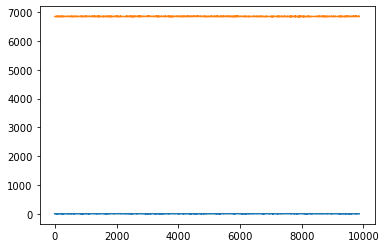

In [11]:
plt.plot(np.real(temp), label="I")
plt.plot(np.imag(temp), label="Q")
amplitude = np.abs(temp).mean()
print(amplitude)